In [1]:
generate_data = False

## Arrest phase diagram for pulses with stress barrier:

We set up pulses for arrest using the steady state solution (choose $u(0) = 2\tau/\gamma$). This reduces the arrest length approximation to

\begin{equation}
L_{arrest} = \frac{2 \log(\frac{\tau_{barrier} - \tau}{\tau_{barrier}})}{\gamma}
\end{equation}

In the following, we set up a fixed $\gamma = 0.65$ and vary $\tau$ and $\tau_{barrier}$ to create a 2D phase diagram of the arrest length

In [2]:
import numpy as np
import run_continuum as run
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.signal
import scipy as scp
import scipy.io as sio
import pickle
import warnings
warnings.filterwarnings('ignore')

from frictionlaws import SlipWeakeningFrictionLaw
from predictions import *

In [3]:
gamma = 0.65
barrier_x = 40
dt = 1e-3
tmax = 200
beta = 1e-3
output_interval = 50
x = np.linspace(0,100,10000)

if generate_data:
    
    tau_all = np.logspace(-2,0,25)
    tau_barrier_all = -np.logspace(-2,0,25)

    L_arrest = np.zeros([np.size(tau_all),np.size(tau_barrier_all)])

    data = []

    for i in range(np.size(tau_all)):
        print(i)        
        for j in range(np.size(tau_barrier_all)):
            tau = gauss(x,0,1)*(1-tau_all[i]) + tau_all[i]
            tau[0]=1
            tau[x>barrier_x]=tau_barrier_all[j]

            # run
            data = run.run_continuum(x = x, tau = tau, tau_minus = tau+2, dt = dt, output_interval = output_interval, gamma = gamma, tmax = tmax, beta = beta)
#            data.append(run.run_continuum(x = x, tau = tau, tau_minus = tau+2, dt = dt, output_interval = output_interval, gamma = gamma, tmax = tmax, beta = beta))

            # Find L_arrest
            L_arrest[i,j]=x[np.max(np.where(data['u'][:,-1]>0))]-barrier_x

    pickle.dump({'data': data, 'L_arrest': L_arrest, 'tau_barrier_all': tau_barrier_all, 'tau_all': tau_all},  open( "data/data_figure_pulse_stress_barrier.p", "wb" ))
else:
    data = pickle.load( open( "data/data_figure_pulse_stress_barrier.p", "rb" ) )
    L_arrest = data['L_arrest']
    tau_all = data['tau_all']
    tau_barrier_all = data['tau_barrier_all']
        

In [4]:
# Calculate prediction:
tau_all_pred = np.logspace(-2,0,250)
tau_barrier_all_pred = -np.logspace(-2,0,250)
L_arrest_pred = np.zeros([np.size(tau_all_pred),np.size(tau_barrier_all_pred)])

x_barrier = 40
for i in range(np.size(tau_all_pred)):
    for j in range(np.size(tau_barrier_all_pred)):
        L_arrest_pred[i,j]=2/gamma*np.log((tau_barrier_all_pred[j]-tau_all_pred[i])/tau_barrier_all_pred[j])
        

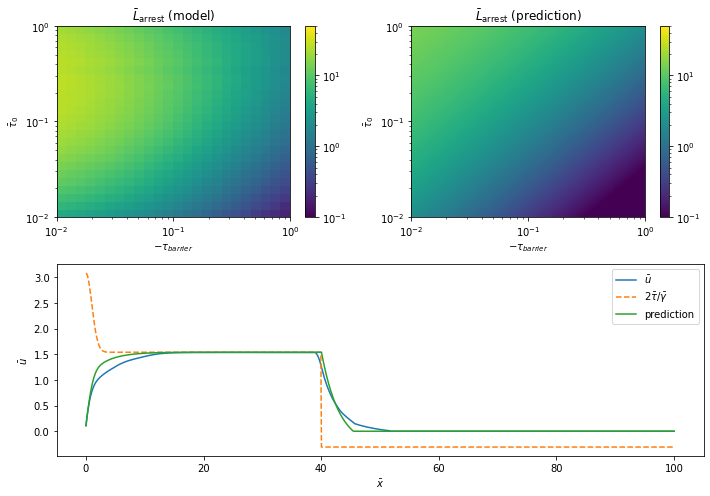

In [5]:
plt.figure(figsize=(10,7))

plt.subplot(2,2,1)
L = L_arrest
L[L<=1e-1]=1e-1
plt.pcolormesh(-tau_barrier_all,tau_all,L,norm=colors.LogNorm(vmin=1e-1, vmax=50))
plt.yscale('log')
plt.xscale('log')
plt.colorbar()
plt.xlabel('$-\\tau_{barrier}$')
plt.ylabel('$\\bar \\tau_0$')
plt.title('$\\bar L_\mathrm{arrest}$ (model)')

plt.subplot(2,2,2)
plt.pcolormesh(-tau_barrier_all_pred,tau_all_pred,L_arrest_pred,norm=colors.LogNorm(vmin=1e-1, vmax=50))
plt.colorbar()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$-\\tau_{barrier}$')
plt.ylabel('$\\bar \\tau_0$')
plt.title('$\\bar L_\mathrm{arrest}$ (prediction)')

plt.subplot(2,2,(3,4))
x = np.linspace(0,100,1000)
tau = gauss(x,0,1)*(1-.5) + .5
tau[0]=1
tau[x>barrier_x]=-.1
data = run.run_continuum(x = x, tau = tau, tau_minus = tau+2, dt = dt, output_interval = output_interval, gamma = gamma, tmax = tmax, beta = beta)
u_pred = PulsePrediction(startPos = 0, u = data['u'], x = data['x'],tau = data['tau'], gamma = data['gamma'],dc = 0)

plt.plot(data['x'],data['u'][:,-1],label='$\\bar u$')
plt.plot(data['x'],2*data['tau']/data['gamma'],label='$2\\bar \\tau/\\bar \\gamma$',linestyle='--')
plt.plot(data['x'],u_pred,label='prediction',linestyle='-')    
plt.xlabel('$\\bar x$')
plt.ylabel('$\\bar u$')    
plt.legend()
plt.tight_layout()

#plt.savefig('figures/arrest_length_tau.eps', format='eps')

plt.show()